# Synthesized Observations

We use Maria to generate synthetic mock observations for bolometric arrays installed on single-dish telescopes. We have developed a wrapper called 'Simulation,' which emulates telescopes like ACT, Toltec, GBT, and AtLAST. This wrapper generates time-ordered domain (TOD) data. By simulating distinct atmospheric layers corresponding to the designated site within the simulation, we allow the mock array to sweep across the input celestial sky while scanning through evolving atmosphere. As a result, the TODs produced combine elements of the real sky, atmospheric effects. This approach generates synthetic observations taking into account atmospheric filtering. 

This tutorial will guide you through the process of setting up the simulation tool and creating your own mock observations.

In [1]:
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
import cmocean

from astropy.io import fits
from astropy.wcs import WCS
from astropy import units as u
from astropy.coordinates import SkyCoord

In [2]:
from maria import Simulation
from maria import mappers
from maria import TOD

## Setting up a MUSTANG-2 Simulation
The ```Simulation``` class offers flexibility for customizing atmospheric simulations. You can configure it to replicate observatories like 'AtLAST' at the APEX site or simulate specific observations, such as MUSTANG-2, under different weather conditions by adjusting the 'weather_quantiles' parameter within the Simulation keywords.

Additionally, the ```Simulation``` class allows you to explore how different scanning strategies impact large-scale filtering. Standard strategies, like back-and-forth or Daisy scan patterns, are implemented for this purpose. For comprehensive documentation on all available keywords, please refer to our detailed documentation. 

Now, let's initiate an example of a mock observation involving a galaxy cluster merger event at redshift 1, observed via the SZ effect, using the Mustang-2 instrument:

### Hyper params

### Initialize
First we need to initialize the telescope and weather conditions

In [3]:
pointing_center = (73.5287496858916, 2.961663679507145)
pixel_size = 8.71452898559111e-05
integration_time = 8.5 * 60.0
sample_rate = 100
scan_velocity =38/3600

inputfile = "../../../maps/cluster.fits"
outfile_tbl = "/tmp/Cluster_45min_noisy_table.fits"
outfile_map = "/tmp/Cluster_45min_noisy_map.fits"

atm_model = "single_layer"
white_noise_level = 1.5e-2
pink_noise_level  = 2.4

In [4]:
sim = Simulation(
    # Mandatory minimal weither settings
    # ---------------------
    array="MUSTANG-2",  # Array type
    pointing="daisy",  # Scanning strategy
    site="GBT",  # Site
    atm_model=atm_model,
    white_noise_level=white_noise_level,
    pink_noise_level=pink_noise_level,
    # True sky input
    # ---------------------
    map_file=inputfile,  # Input files must be a fits file.
    map_units="Jy/pixel",  # Units of the input map in Kelvin Rayleigh Jeans (K, defeault) or Jy/pixel
    map_res=pixel_size,  # degree, overwrites header information
    map_center=pointing_center,  # RA & Dec in degree
    
    # MUSTANG-2 Observational setup
    # ----------------------------s
    scan_options = {
        "radius":  4.0 / 60.0,  # The radius of the Daisy scan in degrees
        "speed":  scan_velocity # scan velocity in deg/s
    },

    integration_time=integration_time,  # Seconds
    sample_rate=sample_rate,  # Hz
    scan_center=pointing_center,  # Degrees
    
    pointing_frame="ra_dec",  # Frame
    start_time="2022-02-11T23:00:00",
    pwv_rms_frac=0.005,
    layer_height=3e3
)

### Obtaining time-ordered data (TODs)
To acquire time-ordered data (TODs), you only need to run the script. The TOD object contains time stamps, coordinates (in RA and Dec), and the intensity of each scan for every detector. The intensity units are consistently expressed in surface brightness temperature units: Kelvin Rayleigh-Jeans (Even if the input map is given in Jy/pixel. We convert the units under the hood).

In [5]:
tod = sim.run()

Sampling atmosphere: 100%|██████████| 1/1 [00:03<00:00,  3.73s/it]


In [6]:
# to save the fits table (could be a Giga Byte of data)
tod.to_fits(outfile_tbl)

The above class generates a synthethic TOD. However, if you would rather use a real tod, such as for instance those from MUSTANG-2 observations. You can also run the following set of commands (for now commented out):

In [7]:
# fname = "/Users/jvanmarr/Documents/Papers/mock_obs/sims/data/Signal_TOD-AGBT21B_206_01-s12.fits"

# tod = TOD()
# tod.from_fits(filename=fname, array="MUSTANG-2")

### Usefull visualizations:
Before proceeding, we first need to adjust the input sky as specified in the Simulation class above.

In [8]:
# - Input figure
hdu = fits.open(inputfile)
hdu[0].data = hdu[0].data
header = hdu[0].header

header["CDELT1"] = pixel_size  # degree
header["CDELT2"] = pixel_size  # degree
header["CTYPE1"] = "RA---SIN"
header["CUNIT1"] = "deg     "
header["CTYPE2"] = "DEC--SIN"
header["CUNIT2"] = "deg     "
header["CRVAL1"] = pointing_center[0]
header["CRVAL2"] = pointing_center[1]
wcs_input = WCS(header, naxis=2)

Now, let's visualize the scanning strategy and the TOD. The top two panels display the scanning trajectory in the elevation and azimuthal plane, while on the right, we present it on the celestial plane. This allows you to check if the scanning pattern aligns with the astronomical source.

The two bottom panels show the mean powerspectra and time series of the observations.

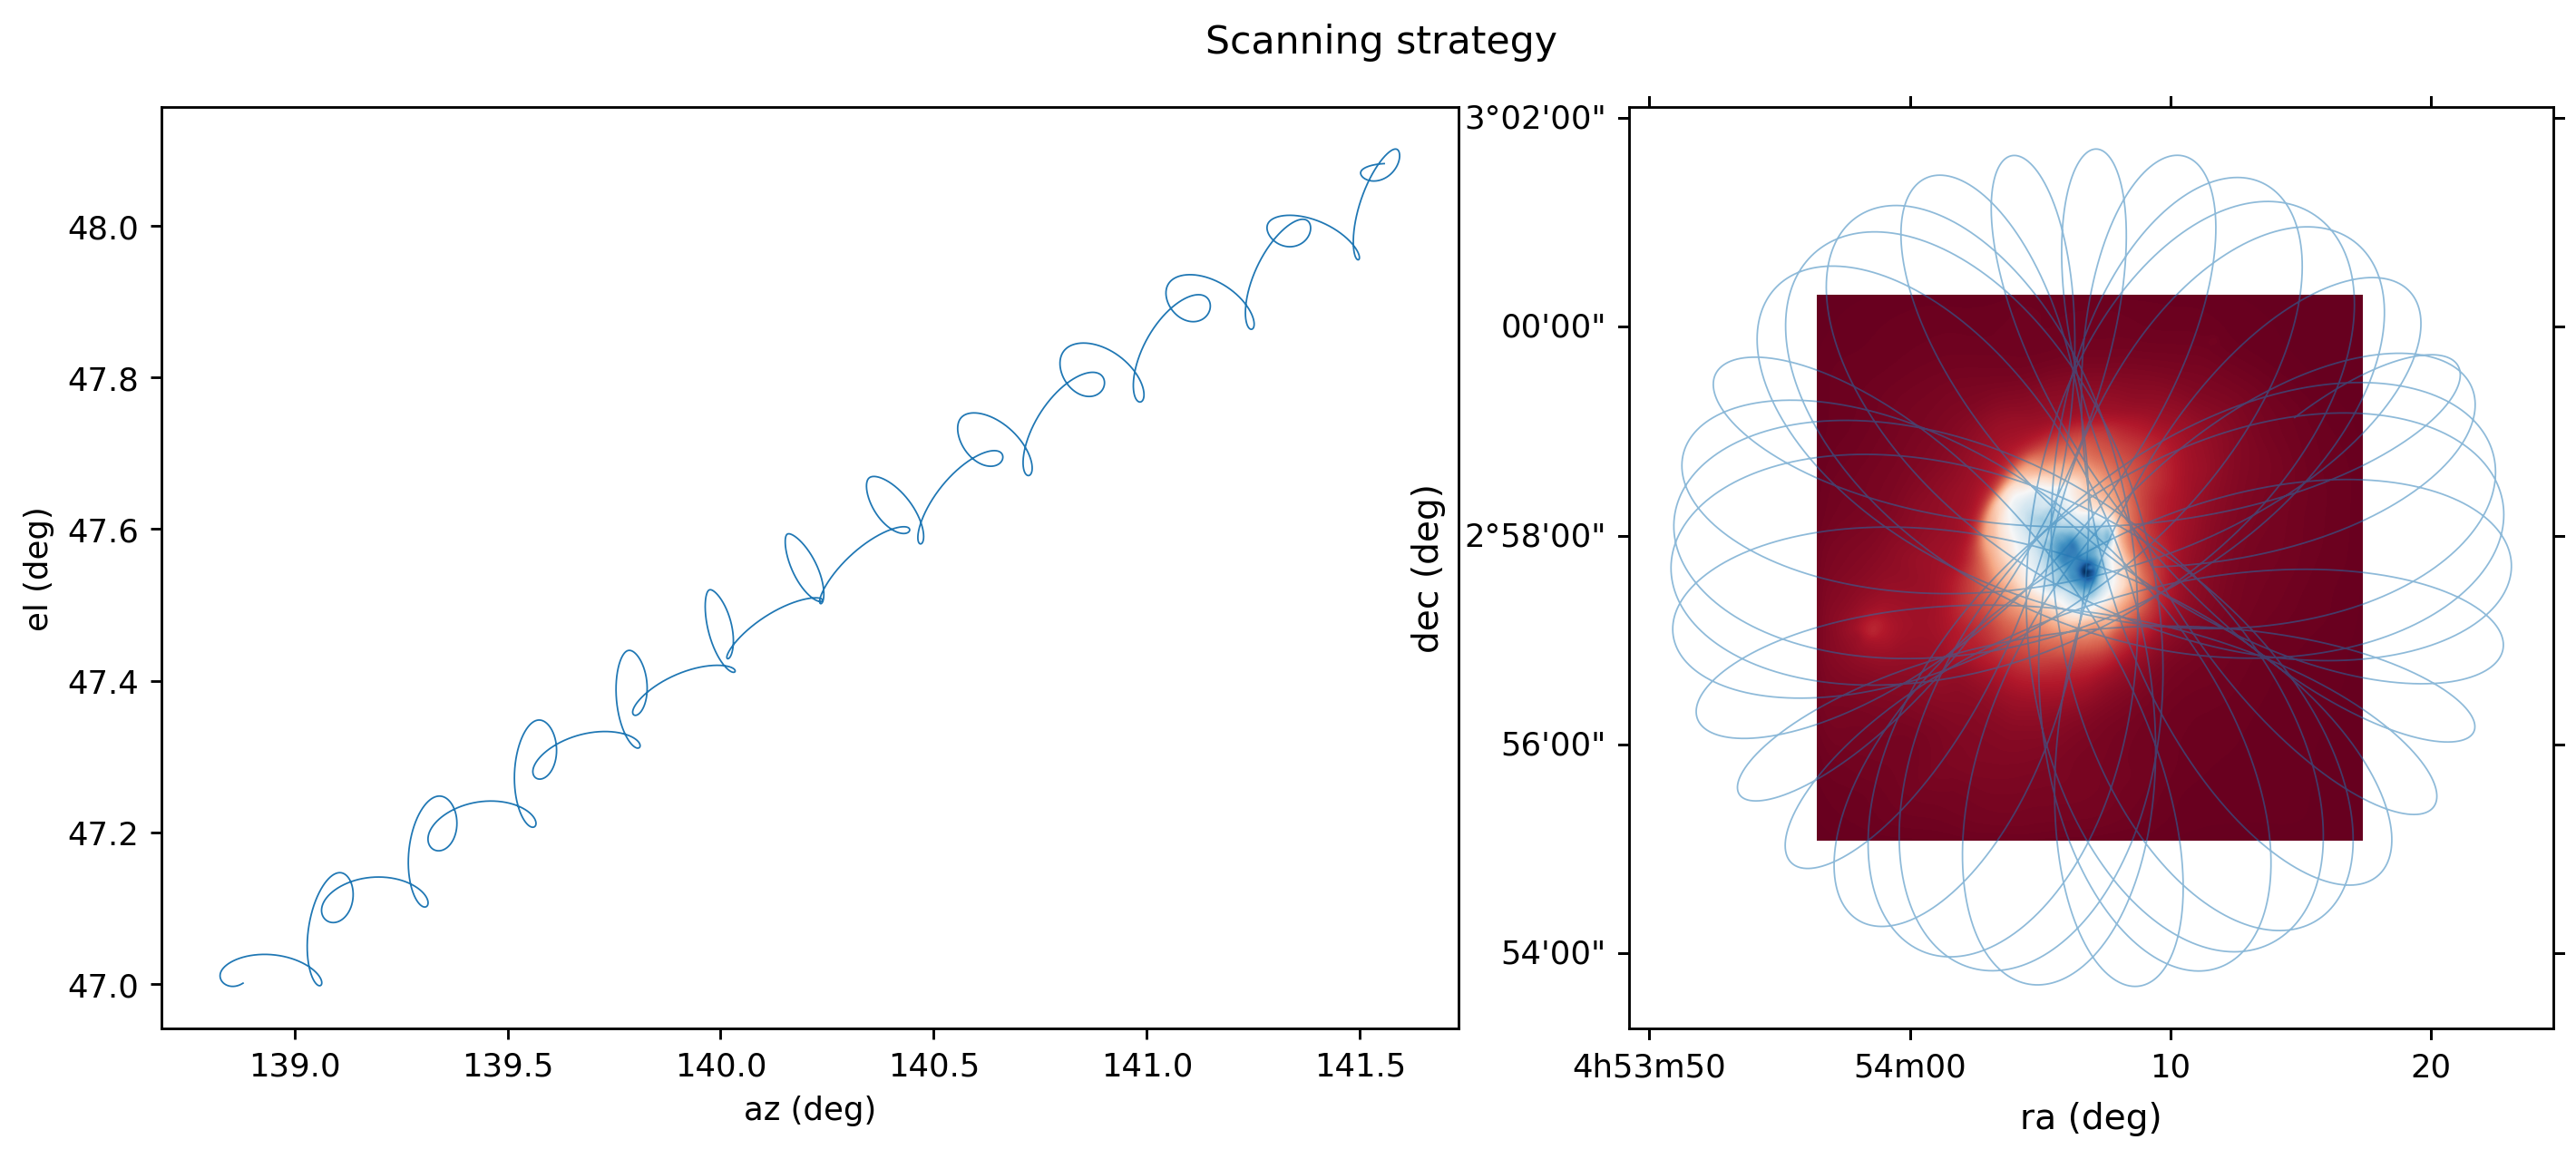

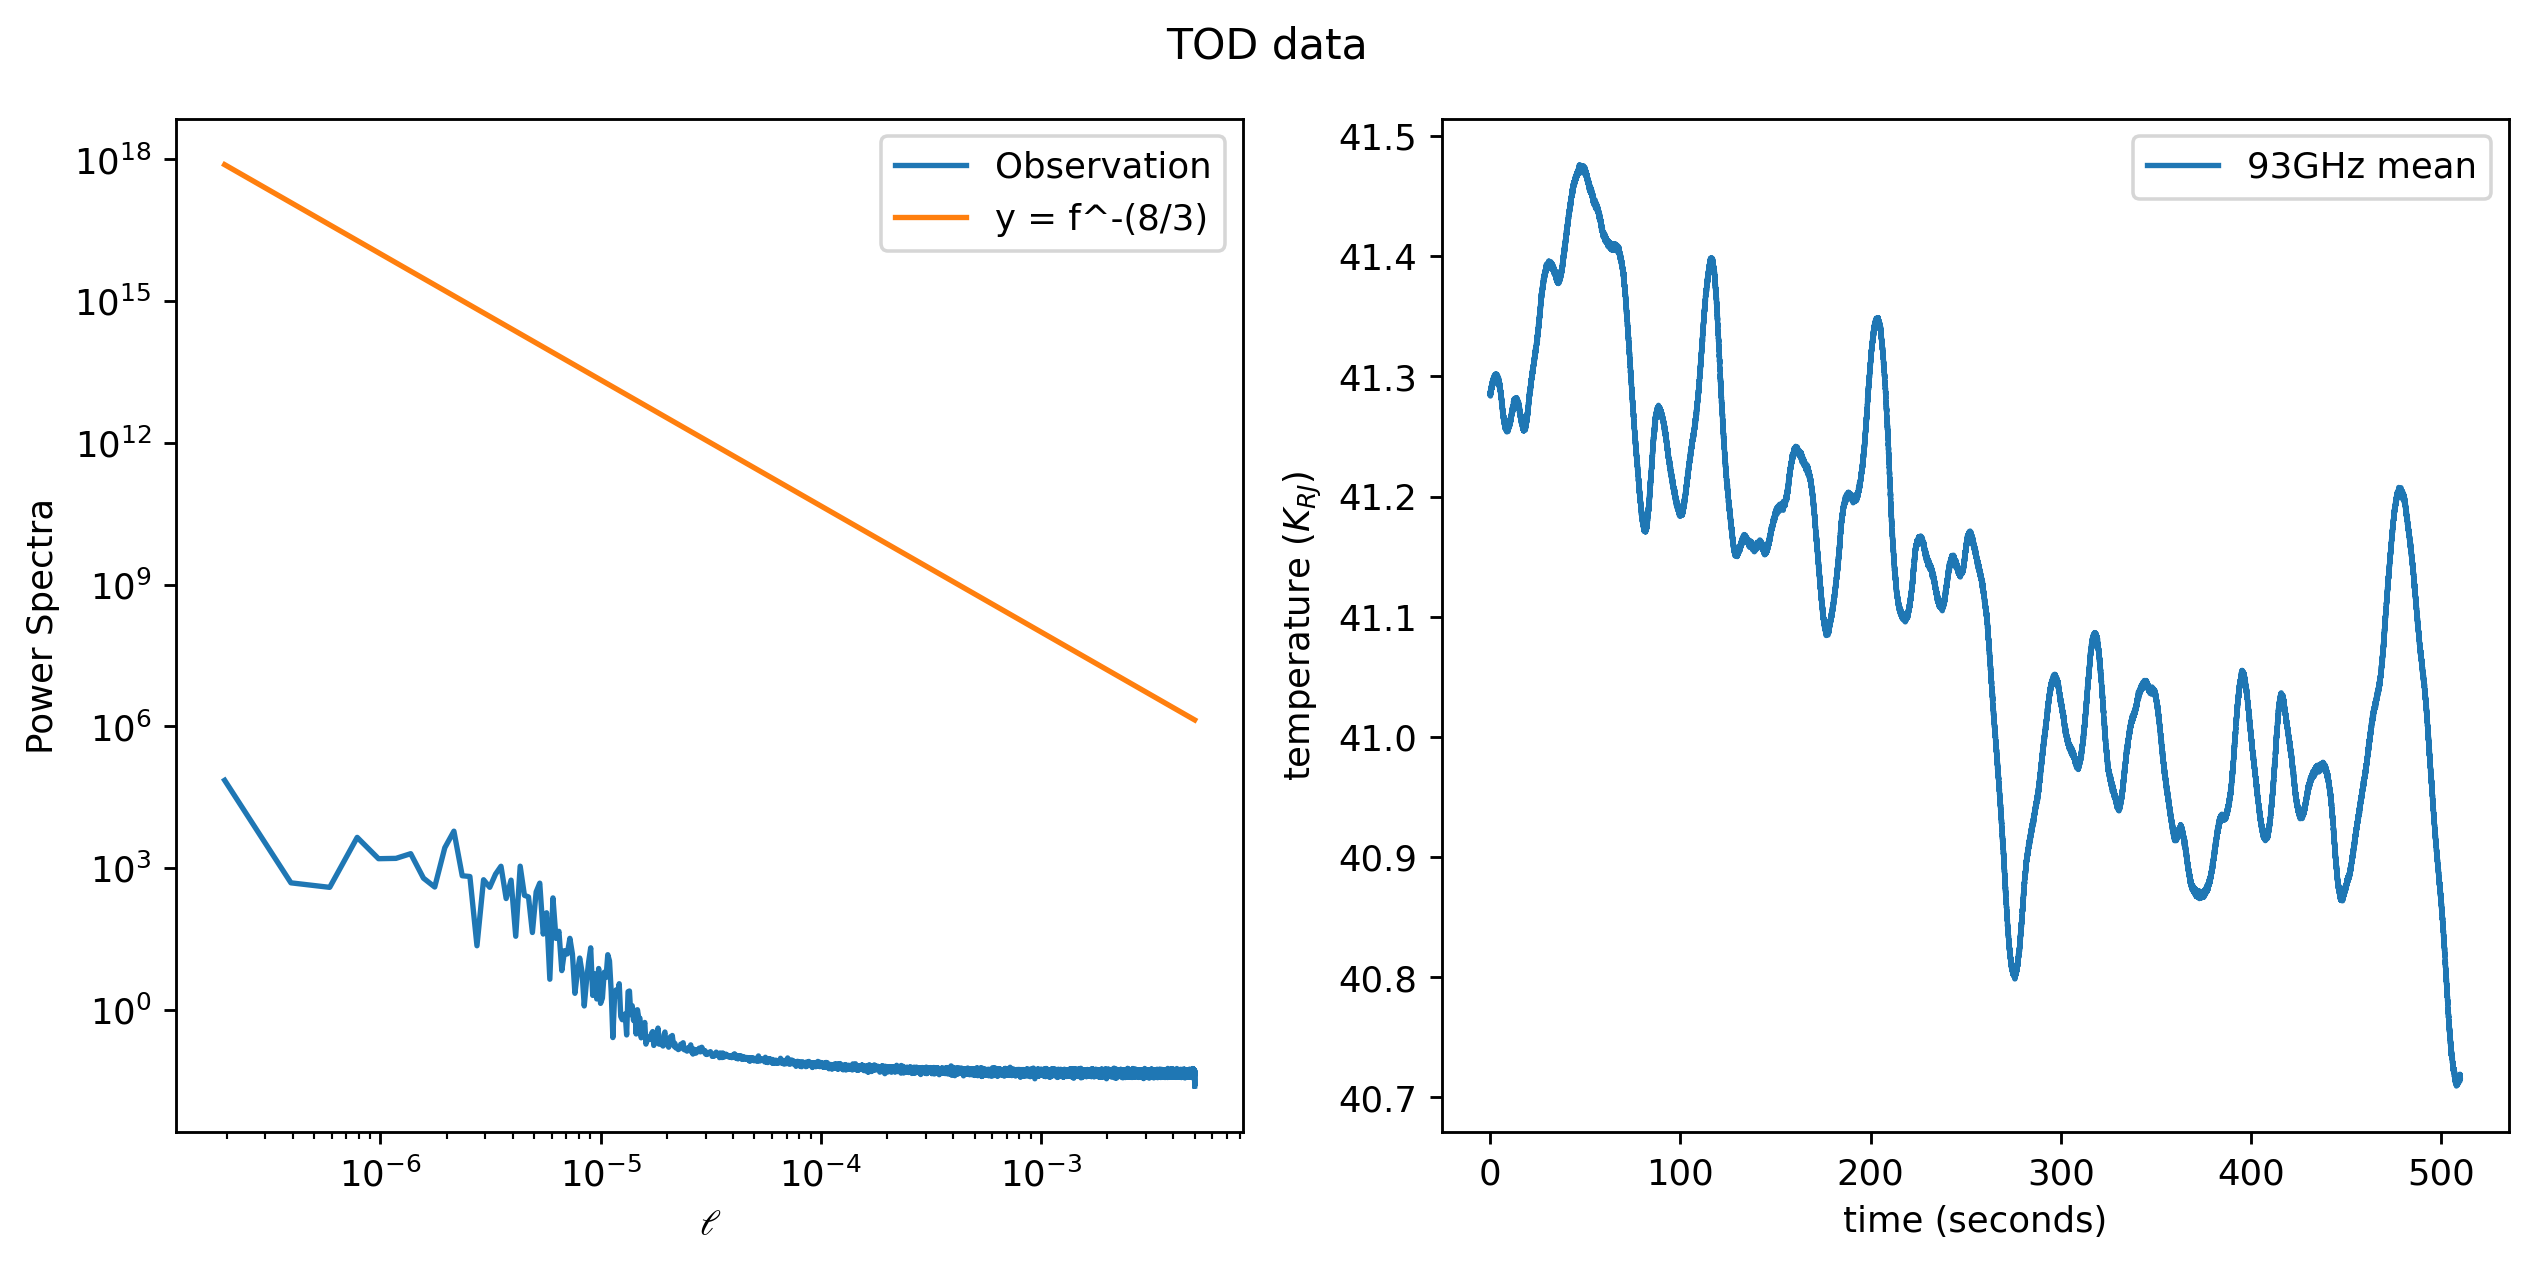

In [9]:
# visualize scanning patern
# -----------------------
cmap = "RdBu_r"

fig = plt.figure(dpi=256, tight_layout=True)
fig.set_size_inches(12, 5, forward=True)
fig.suptitle("Scanning strategy")

# - Plot
ax = plt.subplot(1, 2, 1)

ax.plot(np.degrees(tod.az), np.degrees(tod.el), lw=5e-1)
ax.set_xlabel("az (deg)"), ax.set_ylabel("el (deg)")

ax = plt.subplot(1, 2, 2, projection=wcs_input)
im = ax.imshow(hdu[0].data, cmap=cmap)

ra, dec = ax.coords
ra.set_major_formatter("hh:mm:ss")
dec.set_major_formatter("dd:mm:ss")
ra.set_axislabel(r"RA [J2000]", size=11)
dec.set_axislabel(r"Dec [J2000]", size=11)
ra.set_separator(("h", "m"))

sky = SkyCoord(np.degrees(tod.ra) * u.deg, np.degrees(tod.dec) * u.deg)
pixel_sky = wcs_input.world_to_pixel(sky)
ax.plot(pixel_sky[0], pixel_sky[1], lw=5e-1, alpha=0.5)
ax.set_xlabel("ra (deg)"), ax.set_ylabel("dec (deg)")
plt.show()

# visualize powerspectrum
# -----------------------
f, ps = sp.signal.periodogram(tod.data, fs=tod.time[1] - tod.time[0], window="tukey")

fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=256, tight_layout=True)
fig.suptitle("TOD data")
axes[0].plot(f[1:], ps.mean(axis=0)[1:], label="Observation")
axes[0].plot(f[1:], f[1:] ** (-8 / 3), label="y = f^-(8/3)")
axes[0].set_xlabel(r"$\mathscr{l}$"), axes[0].set_ylabel("Power Spectra")
axes[0].loglog(), axes[0].legend()

for uib, uband in enumerate(np.unique(tod.dets.band)):
    band_mask = tod.dets.band == uband
    band_mean = tod.data[band_mask].mean(axis=0)
    axes[1].plot(tod.time - tod.time[0], band_mean, label=f"{uband} mean")

axes[1].set_xlabel("time (seconds)"), axes[1].set_ylabel(r"temperature ($K_{RJ}$)")
axes[1].legend()

plt.show()

## Mapping the TODs
To transform the TODs into images, you'll require a mapper. While you have the option to create your custom mapper using the saved TODs, we have also included a pre-implemented choice for your convenience. This built-in mapper follows a straightforward approach: it first fourier fitlers the time-streams to remove any noise smaller than the resolution of the dish and larger than the FOV. You can turn this filtering of by setting ```map_filter=False```. Then, we also remove the common mode in the timestream. We do this by removing the first eigenmode (set by ```n_modes_to_remove=1```). Then, the mapper structures the TOD on the specified grid. Notably, the mapper is designed to effectively eliminate correlated atmospheric noise among different scans, thereby enhancing the quality of the resulting images.

An example of how to run the mapper on the TOD is as follows:

In [10]:
mapper = mappers.BinMapper(
    map_height=np.radians(10 / 60),
    map_width=np.radians(10 / 60),
    map_res=np.radians(2 / 3600),
    map_filter=True,
    n_modes_to_remove=1,
)
mapper.add_tods(tod)
mapper.run()

The mapper utilizes the array information specified in the ```Simulation``` class. Below, I show the detector positions in the plane of the sky. The adjacent figure illustrates how many times a detector passed over a pixel on the map, which is related to map sensitivity and the specialized scanning strategy mentioned earlier.

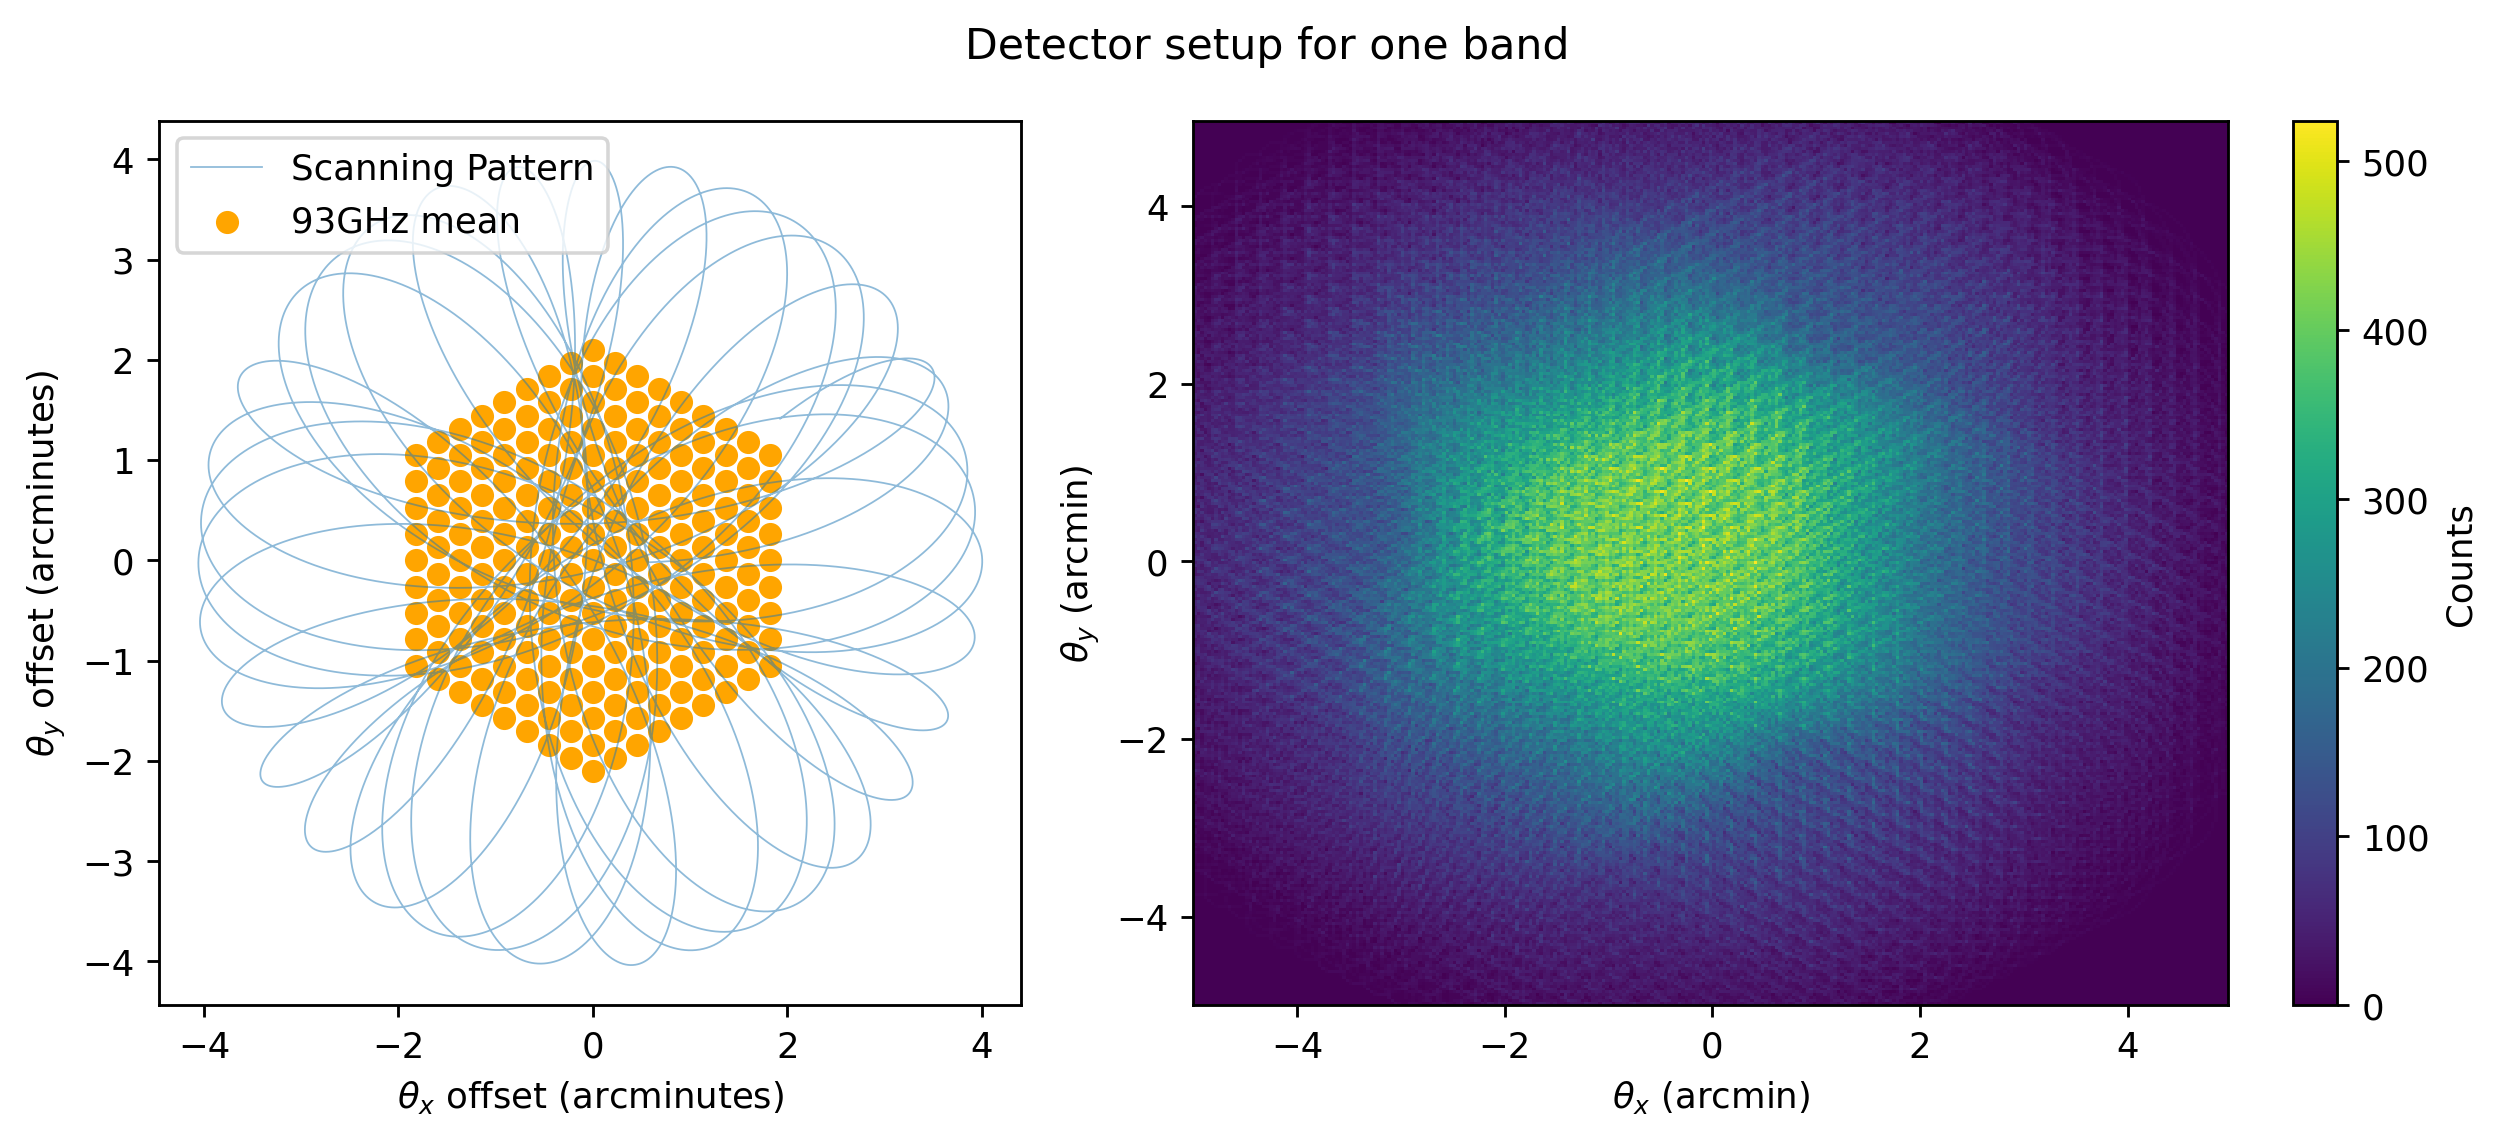

In [11]:
fig, axes = plt.subplots(
    1,
    2,
    figsize=(10, 4.5),
    dpi=256,
    tight_layout=True,
    gridspec_kw={"width_ratios": [1, 1.5]},
)
fig.suptitle("Detector setup for one band")

for uband in sim.array.ubands:
    band_mask = sim.array.dets.band == uband

    axes[0].plot(
        60 * np.degrees(tod.ra - tod.ra.mean()),
        60 * np.degrees(tod.dec - tod.dec.mean()),
        lw=5e-1,
        alpha=0.5,
        label="Scanning Pattern",
    )
    axes[0].scatter(
        60 * np.degrees(sim.array.offset_x[band_mask]),
        60 * np.degrees(sim.array.offset_y[band_mask]),
        label=f"{uband} mean",
        lw=5e-1,
        c="orange",
    )

axes[0].set_xlabel(r"$\theta_x$ offset (arcminutes)")
axes[0].set_ylabel(r"$\theta_y$ offset (arcminutes)")
axes[0].legend()

xs, ys = np.meshgrid(
    60 * np.rad2deg((mapper.x_bins[1:] + mapper.x_bins[:-1]) / 2),
    60 * np.rad2deg((mapper.y_bins[1:] + mapper.y_bins[:-1]) / 2),
)

im = axes[1].pcolormesh(
    xs,
    ys,
    mapper.map_cnts[tod.dets.band[0]],
    label="Photon counts in band " + tod.dets.band[0],
)

axes[1].set_xlabel(r"$\theta_x$ (arcmin)"), axes[1].set_ylabel(r"$\theta_y$ (arcmin)")
cbar = plt.colorbar(im, ax=axes[1])
cbar.set_label("Counts")
plt.show()

## Visualizing the maps
As interesting as the detector setup, power spectra, and time series are, the goal of this module is to create synthetic images. In order to do that, we first save the maps to fits files, simply by running ```mapper.save_maps()```. This will output the fits and update the header according to the newly set observations. The units of the fits file are the same as specified in the ```Simulation``` class, so in Jy/pixel or in Kelvin Rayleigh Jeans. The saved fits file is a cube with axis (number of bands, pixels, pixels).

In [12]:
mapper.save_maps(outfile_map)

Below, we will visualize the maps we made, this is the final product. 

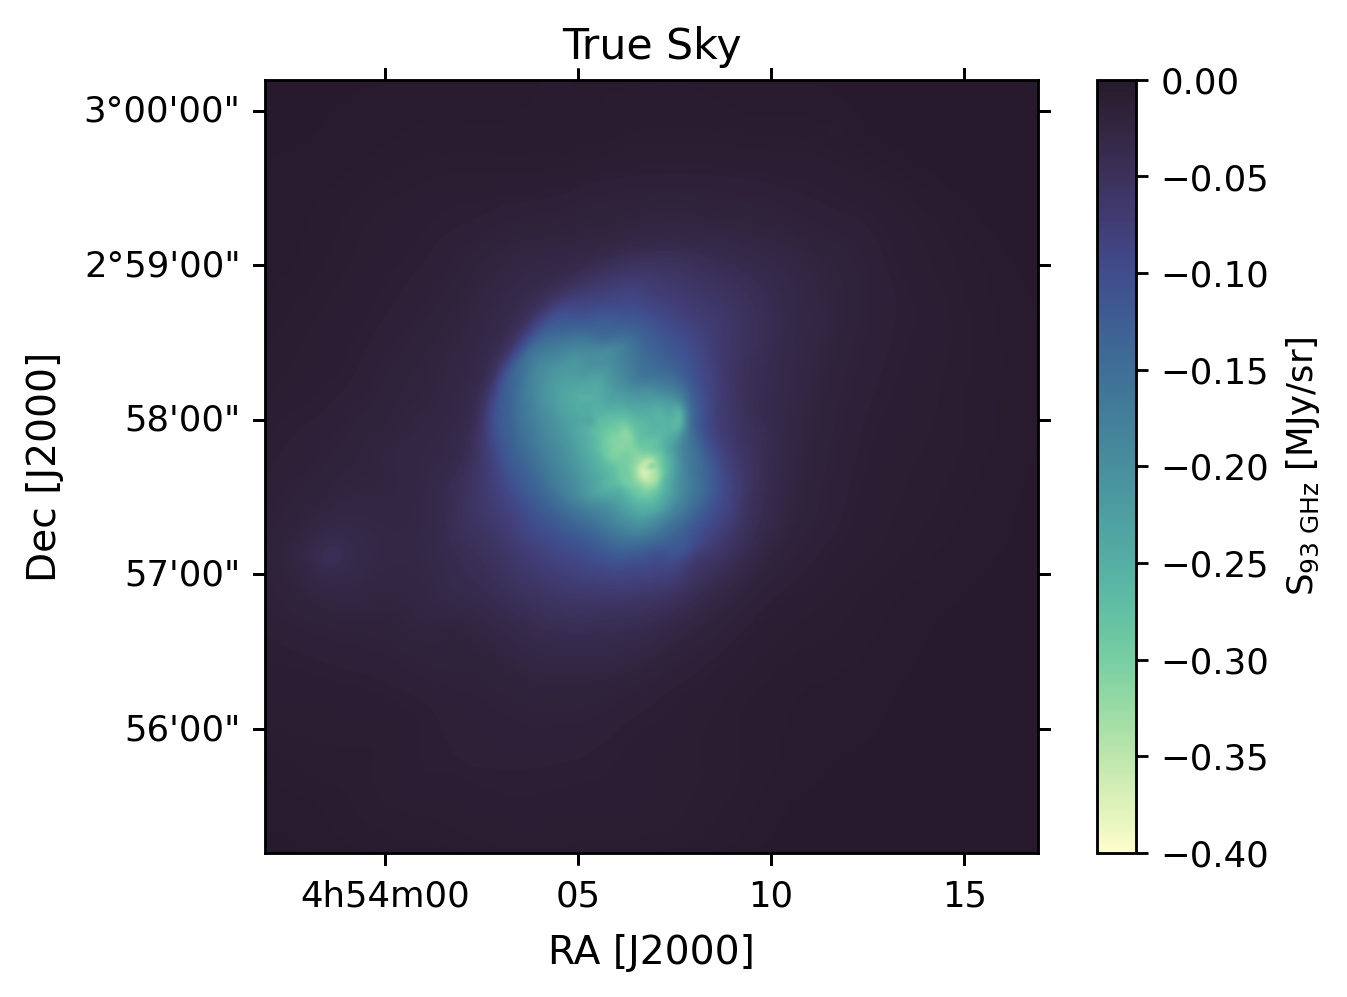

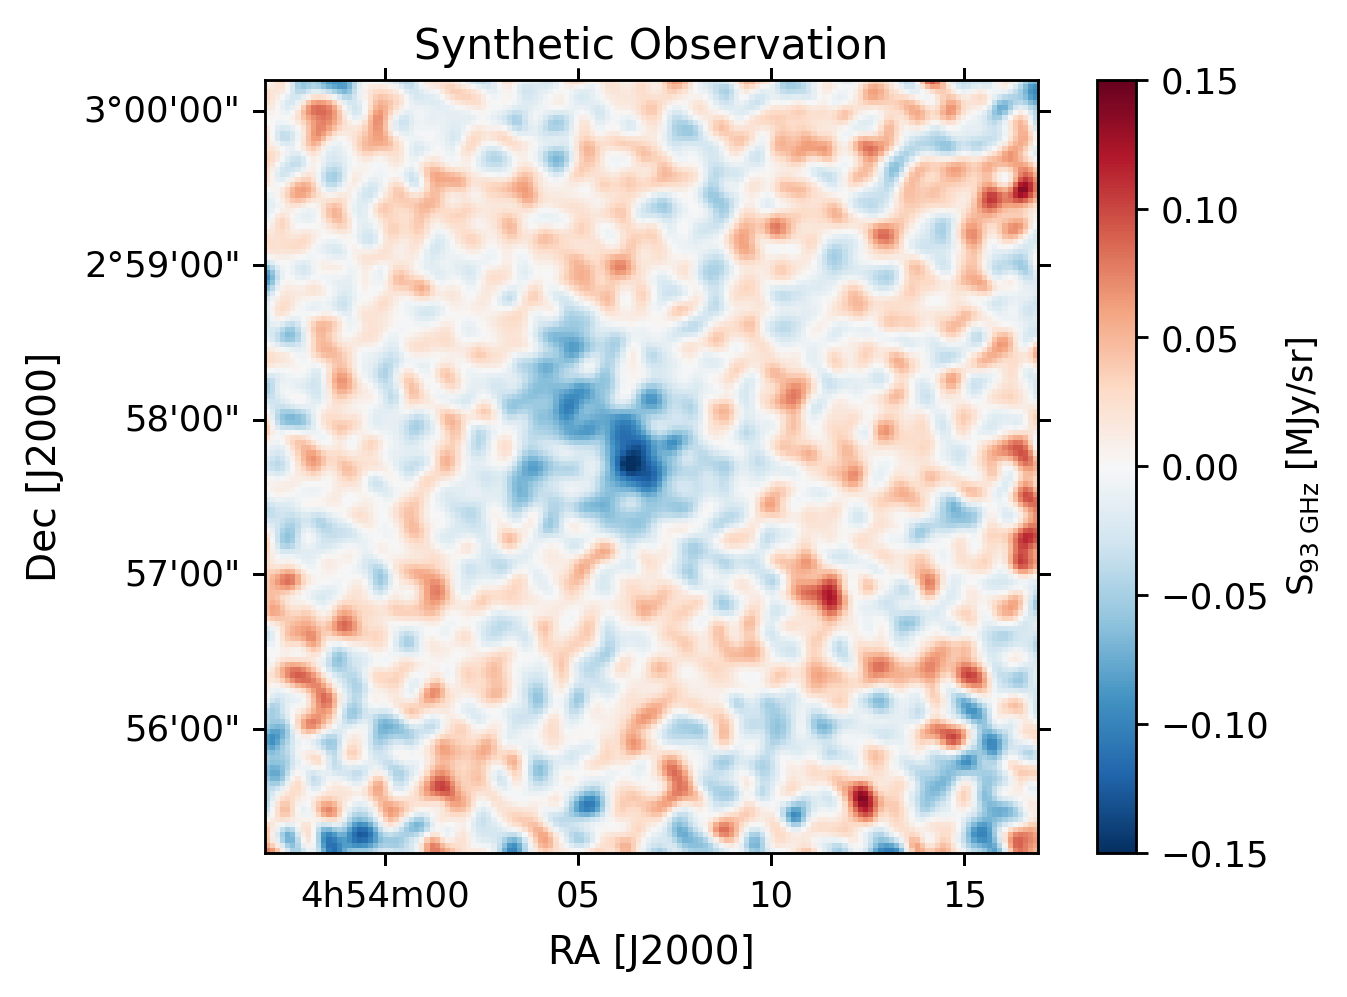

In [13]:
sky_l = SkyCoord(
    (pointing_center[0] - 2.5 / 60) * u.deg, (pointing_center[1] - 2.5 / 60.0) * u.deg
)
sky_u = SkyCoord(
    (pointing_center[0] + 2.5 / 60) * u.deg, (pointing_center[1] + 2.5 / 60.0) * u.deg
)

fig = plt.figure(dpi=256, tight_layout=False)
fig.set_size_inches(6, 4, forward=True)

# - Plot Input sky
ax = plt.subplot(1, 1, 1, projection=wcs_input)
ax.set_title("True Sky")
im = ax.imshow(
    hdu[0].data / (np.radians(pixel_size)) ** 2 / 1e6,
    vmin=-0.4,
    vmax=0,
    cmap=cmocean.cm.deep,
)
cbar = plt.colorbar(im, ax=ax, shrink=1.0)
cbar.set_label(r"S$_{93~\rm GHz}$ [MJy/sr]")

ra, dec = ax.coords
ra.set_major_formatter("hh:mm:ss")
dec.set_major_formatter("dd:mm:ss")
ra.set_axislabel(r"RA [J2000]", size=11)
dec.set_axislabel(r"Dec [J2000]", size=11)
ra.set_separator(("h", "m"))

pixel_sky_l = wcs_input.world_to_pixel(sky_l)
pixel_sky_u = wcs_input.world_to_pixel(sky_u)
ax.axis(
    xmin=pixel_sky_l[0], ymin=pixel_sky_l[1], xmax=pixel_sky_u[0], ymax=pixel_sky_u[1]
)
plt.show()

# - Plot Mock observation
outputfile = outfile_map

hdu_out = fits.open(outputfile)
wcs_output = WCS(hdu_out[0].header, naxis=2)

# - Plot
fig = plt.figure(dpi=256, tight_layout=False)
fig.set_size_inches(6, 4, forward=True)

ax = plt.subplot(1, 1, 1, projection=wcs_output)
ax.set_title("Synthetic Observation")

im = ax.imshow(
    hdu_out[0].data[0] / (mapper.map_res**2) / 1e6, cmap=cmap, vmin=-0.15, vmax=0.15
)

cbar = plt.colorbar(im, ax=ax, shrink=1.0)
cbar.set_label(r"S$_{93~\rm GHz}$ [MJy/sr]")

ra, dec = ax.coords
ra.set_major_formatter("hh:mm:ss")
dec.set_major_formatter("dd:mm:ss")
ra.set_axislabel(r"RA [J2000]", size=11)
dec.set_axislabel(r"Dec [J2000]", size=11)
ra.set_separator(("h", "m"))

pixel_sky_l = wcs_output.world_to_pixel(sky_l)
pixel_sky_u = wcs_output.world_to_pixel(sky_u)

ax.axis(
    xmin=pixel_sky_l[0], ymin=pixel_sky_l[1], xmax=pixel_sky_u[0], ymax=pixel_sky_u[1]
)

plt.show()